In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import omicverse as ov
import pertpy as pt

In [2]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [2]:
adata = sc.read_h5ad('/data/hanxue/hanxue_data/adata-xwt-annotated_T-0429.h5ad')

In [3]:
adata = adata[adata.obs['treat'].isin(['After']), :]

In [4]:
adata.obs['effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['13T', '19T']),'effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['11T', '12T', '16T']),'effect'] = 'worse'

... storing 'effect' as categorical


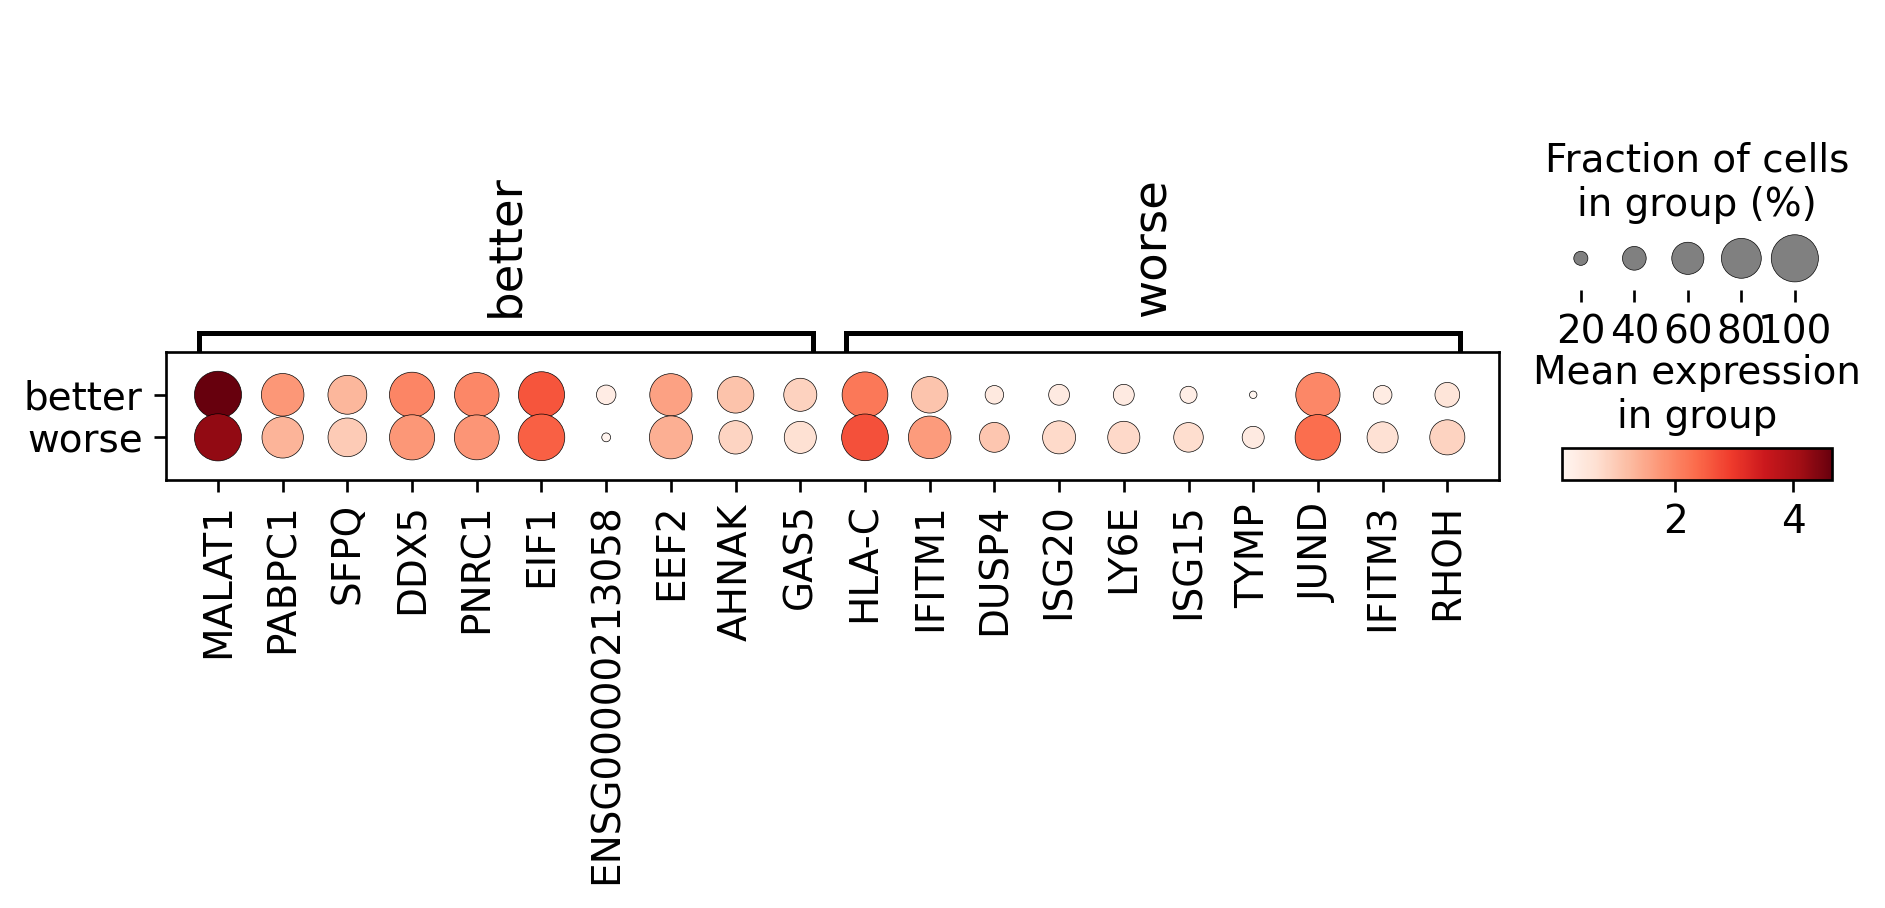

In [9]:
sc.tl.rank_genes_groups(adata, groupby = 'effect', method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, groupby = 'effect', save='-T-effect.svg')

2025-09-09 03:36:15 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:36:15 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:36:15 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:36:15 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:36:15 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

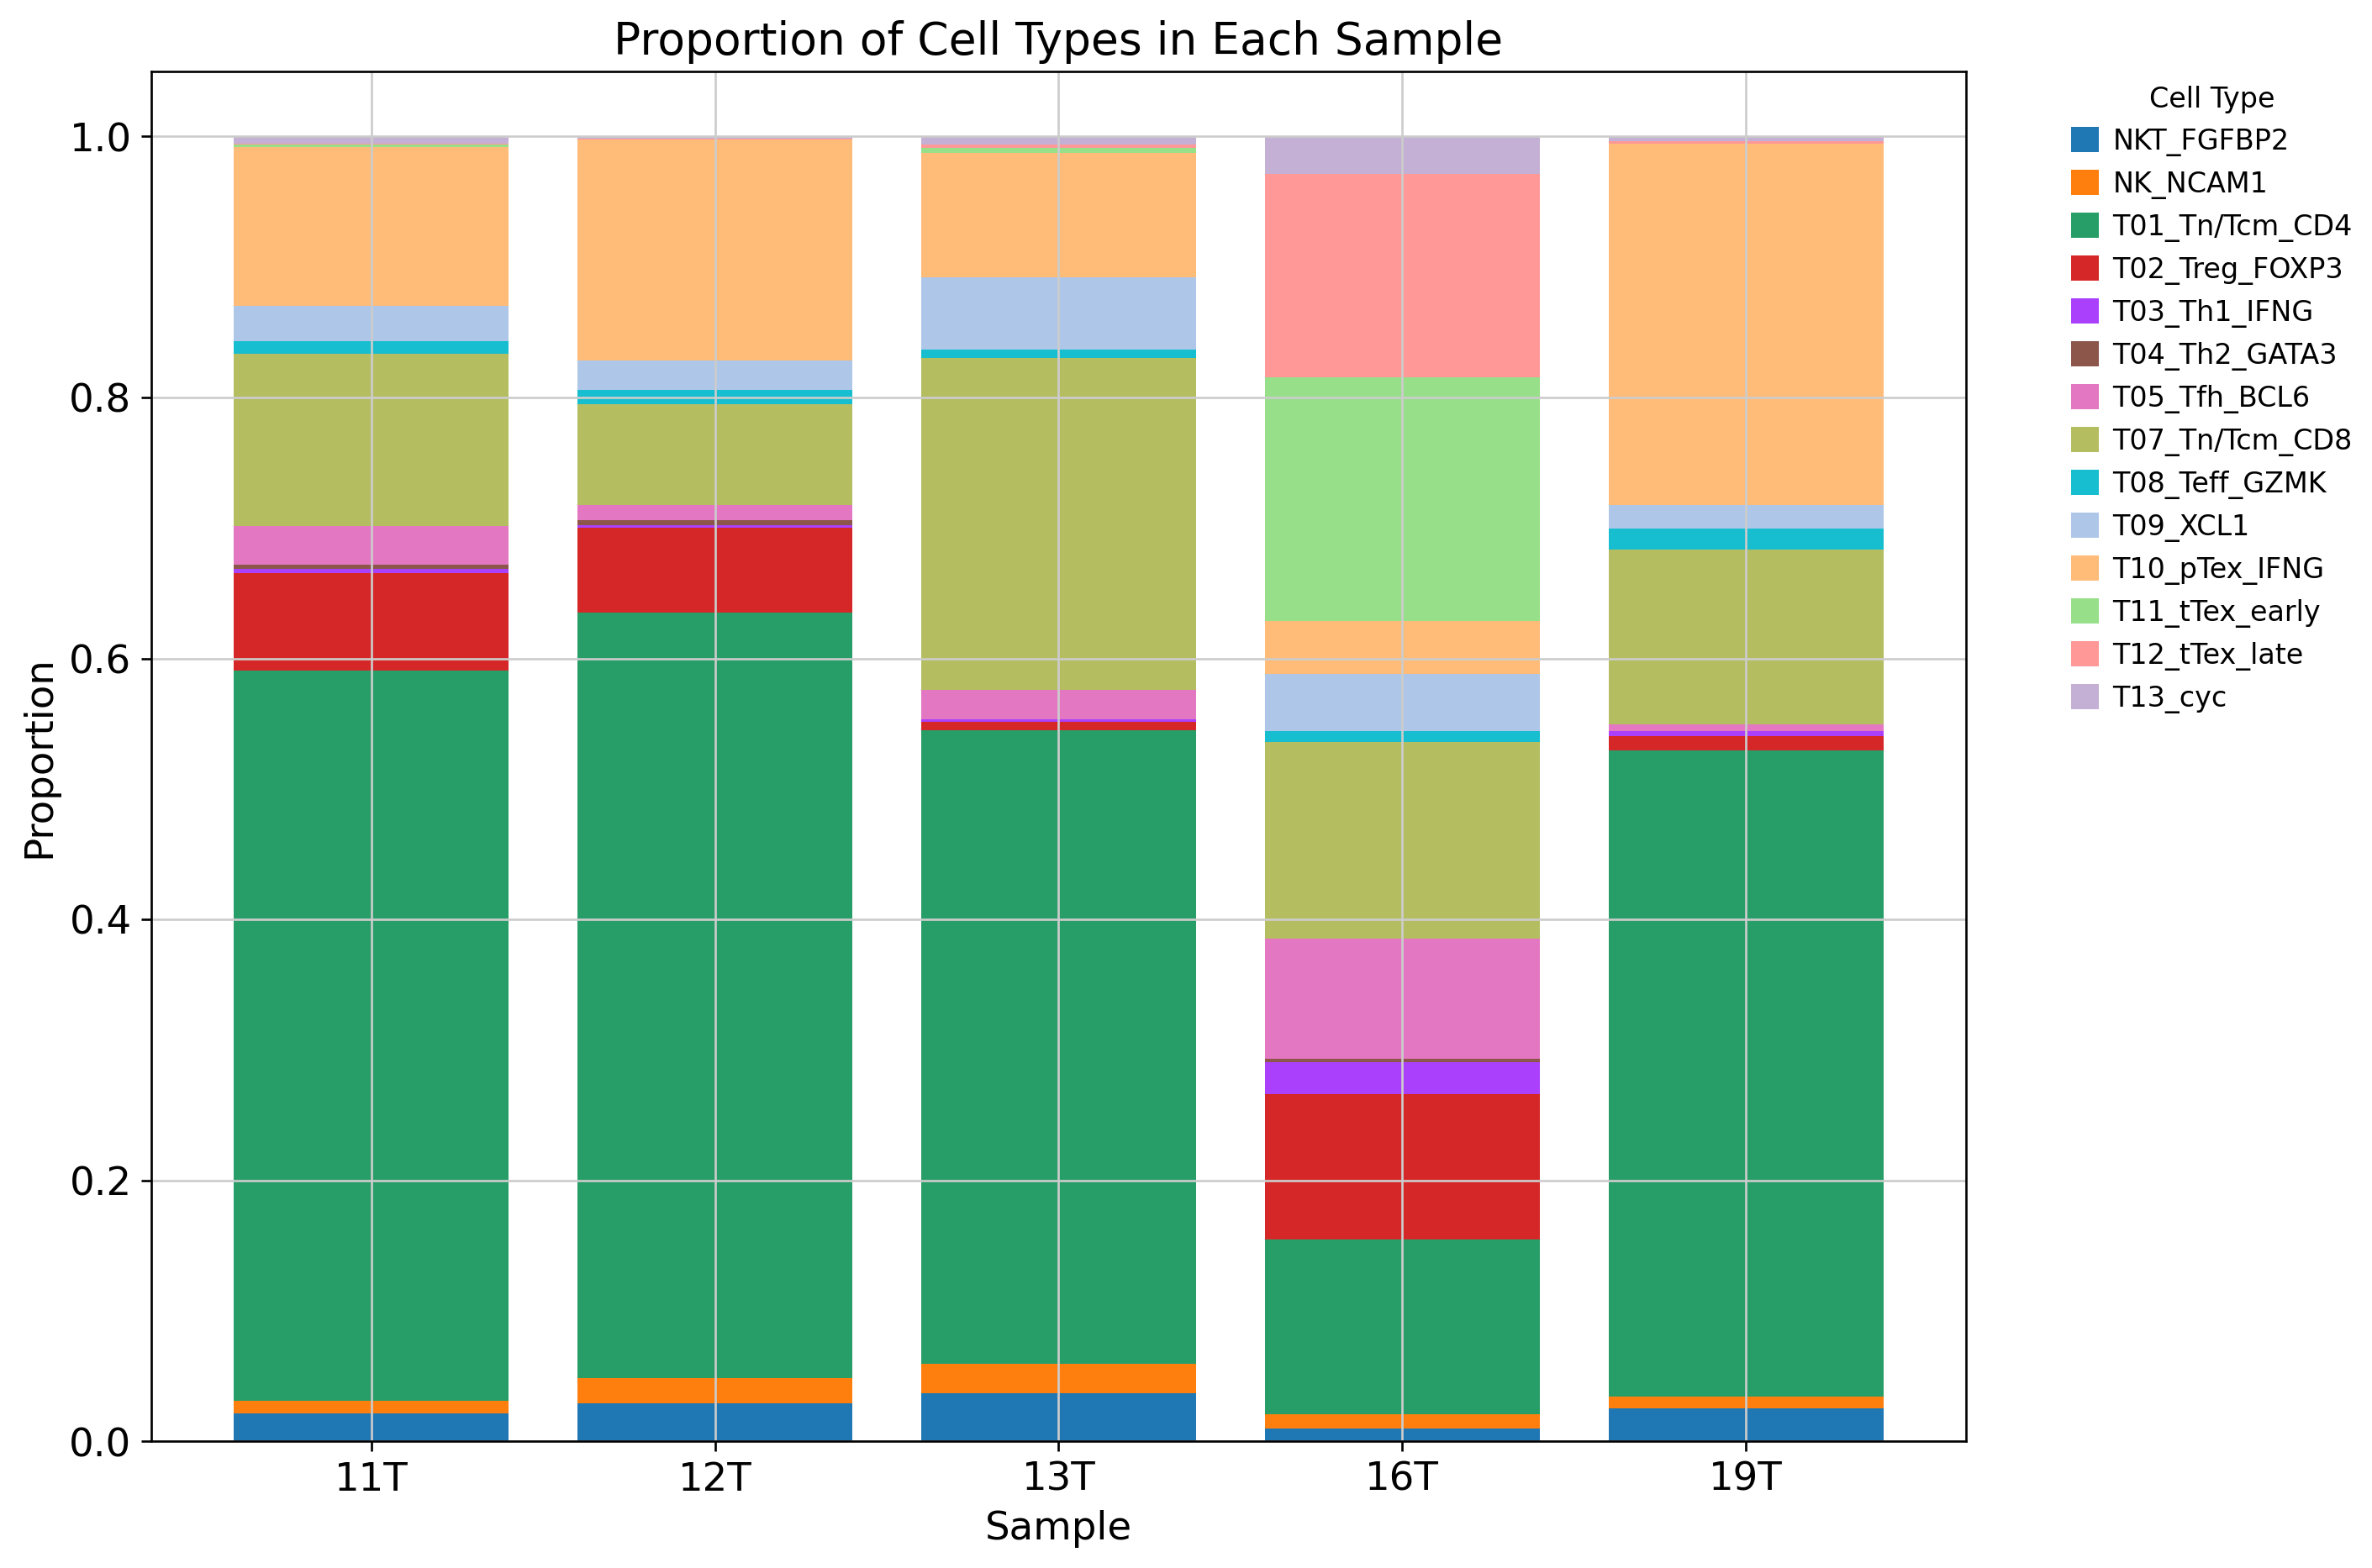

In [10]:
# 1. 计算每个样本中每种细胞类型的数量
cell_type_counts = adata.obs.groupby(['batch', 'anno-subT']).size().unstack(fill_value=0)

# 2. 计算每个样本的总细胞数
sample_totals = cell_type_counts.sum(axis=1)

# 3. 计算每种细胞类型在每个样本中的占比
proportions = cell_type_counts.div(sample_totals, axis=0)

# 4. 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8))

# 遍历每个细胞类型，逐层堆叠
bottom = np.zeros(len(cell_type_counts.index))  # 初始化底部高度
for cell_type in proportions.columns:
    ax.bar(proportions.index, proportions[cell_type], bottom=bottom, label=cell_type)
    bottom += proportions[cell_type]  # 更新底部高度

# 添加标题和标签
ax.set_title('Proportion of Cell Types in Each Sample', fontsize=16)
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.tight_layout()
plt.show()

#### 差异基因

In [9]:
adata = adata[~adata.obs['batch'].isin(['16T']), :]

In [10]:
# 选用高变基因
adata_highvar = adata[:, adata.var['highly_variable']].copy()
dds = ov.bulk.pyDEG(adata_highvar.to_df().T)
dds.drop_duplicates_index()
better_groups = adata_highvar.obs[adata_highvar.obs['effect']=='better'].index.tolist() # 实验组
worse_groups = adata_highvar.obs[adata_highvar.obs['effect']=='worse'].index.tolist() # 对照组
deg_result = dds.deg_analysis(better_groups, worse_groups, method='ttest')
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.
... Fold change threshold: 1.760595440864563


In [11]:
deg_result_filter = deg_result[deg_result['sig'] != 'normal']
deg_result_filter

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
name,,,,,,,,,,,,
MT1X,0.000000e+00,0.000000e+00,3.934635,0.570288,0.357603,-1.483568,1.976230,1.976230,0.393464,inf,10.000000,up
MT1E,0.000000e+00,0.000000e+00,8.443636,0.398838,0.223024,-2.164728,3.077864,3.077864,0.844364,inf,10.000000,up
MGP,0.000000e+00,0.000000e+00,3.597769,0.272801,0.174303,-2.520334,1.847103,1.847103,0.359777,inf,10.000000,up
TNFRSF18,3.266257e-24,7.131566e-24,0.263341,0.141850,0.089592,-3.480494,-1.924998,1.924998,0.026334,23.485950,10.000000,down
MUCL1,0.000000e+00,0.000000e+00,6.752967,0.206133,0.118316,-3.079277,2.755522,2.755522,0.675297,inf,10.000000,up
FOXP3,6.003728e-15,1.289737e-14,0.261836,0.100525,0.063412,-3.979099,-1.933267,1.933267,0.026184,14.221580,10.000000,down
MT1G,2.026175e-27,4.433643e-27,15.001667,0.113002,0.060254,-4.052808,3.907051,3.907051,1.500167,26.693325,10.000000,up
CH25H,5.416157e-11,1.152374e-10,0.107145,0.055137,0.030510,-5.034595,-3.222361,3.222361,0.010715,10.266310,9.938407,down
TRBV7-3,9.985461e-06,2.011170e-05,0.265697,0.048308,0.030561,-5.032161,-1.912148,1.912148,0.026570,5.000632,4.696551,down


In [23]:
deg_result_filter.to_excel("T_effect_deg.xlsx", index=True)

In [7]:
# Better vs Worse include 16T
# 疗效好组上调（更关注）
# 疗效好组上调（Log2FC ≥ 1.2）
up_genes = [
    "MT1G",    # 金属硫蛋白，应激/金属离子稳态
    "MT1X",    # 金属硫蛋白
    "MT1E",    # 金属硫蛋白
    "MT1H",    # 金属硫蛋白
    "TRBV12-4",# TCR β可变区，提示克隆扩增
    "PRR4",    # 组织应激/环境相关转录
    "TRGV4",   # TCR γ可变区，γδT细胞相关
    "TFF3",    # 上皮相关分泌因子，可能为组织环境信号
    "7SK-4"    # 小核RNA家族成员
]

# 疗效好组下调（= 疗效差组上调，Log2FC ≤ -1.2）
down_genes = [
    "CXCL13",  # 趋化因子，TFH-like/耗竭CD8+标志
    "IFI44L",  # 干扰素刺激基因，抗病毒应答
    "TNFRSF18",# GITR，共刺激受体
    "TYMP",    # 胸苷磷酸化酶，代谢-免疫耦联
    "TNFRSF9", # 4-1BB，共刺激受体
    "CTLA4",   # 抑制性受体，免疫检查点
    "IFI6",    # 干扰素刺激基因，应激/凋亡调控
    "BATF",    # 转录因子，效应/耗竭分化
    "DUSP4",   # MAPK去磷酸酶，负调控信号
    "TIGIT",   # 抑制性受体，免疫检查点
    "SERPINH1",# 分子伴侣，基质/应激相关
    "LAG3",    # 抑制性受体，免疫检查点
    "VCAM1",   # 黏附分子，利于浸润；此处下调提示T细胞互作受限
    "CALML5",  # 钙调素样蛋白，信号转导
    "SOX4"     # 转录因子，组织适应/迁移
]

selected_genes = up_genes + down_genes

In [12]:
# Better vs Worse without 16T
# 疗效好组上调（|log2FC| > 1.7）
up_genes = [
    "MT1E",    # 金属硫蛋白，应激/金属离子稳态
    "MT1X",    # 金属硫蛋白，应激耐受与代谢适配
    "MGP",     # 基质相关，组织互作信号
    "MT1G",    # 金属硫蛋白，应激耐受↑
    "MMP7",    # 基质金属蛋白酶，ECM重塑
    "KLRC2",   # NKG2C 受体，细胞毒/活化相关
    "CCL21",   # 趋化因子，淋巴样结构/CCR7相关
]

# 疗效好组下调（= 疗效差上调，|log2FC| > 1.7 且 p < 1e-3）
down_genes = [
    "TNFRSF18",# GITR，共刺激受体
    "CH25H",   # 胆固醇25-羟化酶，免疫代谢
    "FOXP3",   # Treg主转录因子
    "RTKN2",   # Rho信号调节，T细胞存活/迁移
    "TRBV7-3", # TCR β可变区，提示克隆扩增
]

selected_genes = up_genes + down_genes

After cleaning: 1096 rows; labeling 12 genes.
🌋 Volcano Plot Analysis:
   Total genes: 1096
   ↗️  Upregulated genes: 31
   ↘️  Downregulated genes: 18
   ➡️  Non-significant genes: 1047
   🎯 Total significant genes: 49
   log2FC range: -9.41 to 7.77
   qvalue range: 1.00e-50 to 9.98e-01

⚙️  Current Function Parameters:
   Data columns: pval_name='qvalue', fc_name='log2FC'
   Thresholds: pval_threshold=0.001, fc_max=1.5, fc_min=-1.5
   Plot size: figsize=(5, 5)
   Gene labels: plot_genes_num=12, plot_genes_fontsize=8
   Custom genes: 12 specified

💡 Parameter Optimization Suggestions:
   ▶ Wide fold change range detected:
     Current: fc_max=1.5, fc_min=-1.5
     Suggested: fc_max=4.0, fc_min=-4.0

   📋 Copy-paste ready function call:
   ov.pl.volcano(result, fc_max=4.0, fc_min=-4.0, plot_genes=['MT1E', 'MT1X', 'MGP', 'MT1G', 'MMP7', 'KLRC2', 'CCL21', 'TNFRSF18', 'CH25H', 'FOXP3', 'RTKN2', 'TRBV7-3'])
────────────────────────────────────────────────────────────


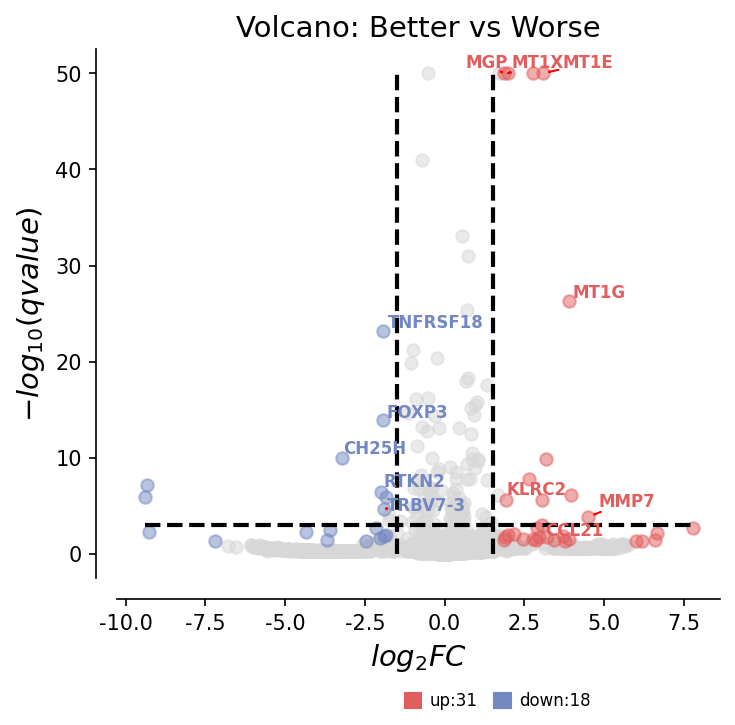

In [13]:
import numpy as np
import pandas as pd

# —— 1) 拷贝并确保基因是索引（若你的基因在第一列而非索引，解除注释下一行）
# deg_result = deg_result.set_index(deg_result.columns[0])

df = deg_result.copy()

# —— 2) 列类型转为数值；把非数字（比如 'nan' 字符串）变成 NaN
for col in ['qvalue', 'log2FC']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# —— 3) 关键：给 qvalue 设置极小正下限，避免 -log10(0) = inf
# 用 float64 能表示的最小正数；也可以改成 1e-300
# eps = np.nextafter(0, 1)
# df['qvalue'] = df['qvalue'].clip(lower=eps)
# 给 qvalue 设下限，保证 -log10(qvalue) ≤ 50
df['qvalue'] = df['qvalue'].clip(lower=10**-50)

# —— 4) 把其余无穷大/无穷小替换成 NaN，再丢弃会影响坐标的行
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['qvalue', 'log2FC'])

# # —— 5) 如果还保留了你自己算的 -log 列，也把 inf 压到有限值，避免后续使用时报错
# for col in ['-log(pvalue)', '-log(qvalue)']:
#     if col in df.columns:
#         finite_mask = np.isfinite(df[col])
#         if (~finite_mask).any() and finite_mask.any():
#             df.loc[~finite_mask, col] = df.loc[finite_mask, col].max() + 1

# —— 5) 如果还保留了你自己算的 -log 列，把 inf 压到上限 50
for col in ['-log(pvalue)', '-log(qvalue)']:
    if col in df.columns:
        # 将 inf / -inf 替换为 NaN
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        # 再用 clip 限制最大值为 50
        df[col] = df[col].clip(upper=50)

# —— 6) 只标注“清洗后仍存在且坐标有限”的基因，避免为无效点加注释
plot_genes = []
for g in selected_genes:
    if g in df.index:
        qv = df.at[g, 'qvalue']
        fc = df.at[g, 'log2FC']
        if np.isfinite(qv) and np.isfinite(fc) and (qv > 0):
            plot_genes.append(g)

print(f"After cleaning: {df.shape[0]} rows; labeling {len(plot_genes)} genes.")

# —— 7) 正式绘图：一定要把 result=df（清洗后的表），并传入原始 qvalue
import matplotlib.pyplot as plt
import omicverse as ov

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
grp1, grp2 = 'Better', 'Worse'

ov.pl.volcano(
    result=df,
    pval_name='qvalue',      # 传原始 qvalue，函数内部会做 -log10
    fc_name='log2FC',
    pval_max=None,
    FC_max=None,
    figsize=(5, 5),
    title=f'Volcano: {grp1} vs {grp2}',
    titlefont={'weight': 'normal', 'size': 14},
    up_color='#e25d5d',
    down_color='#7388c1',
    normal_color='#d7d7d7',
    up_fontcolor='#e25d5d',
    down_fontcolor='#7388c1',
    normal_fontcolor='#d7d7d7',
    legend_bbox=(0.8, -0.2),
    legend_ncol=2,
    legend_fontsize=8,
    # 阈值
    pval_threshold=0.001,
    fc_max=1.5,               # 注意这里是 fc_max（小写）
    # 标注
    plot_genes=plot_genes,
    plot_genes_num=len(plot_genes),
    plot_genes_fontsize=8,
    ticks_fontsize=8,
    ax=ax
)

plt.tight_layout()
plt.savefig("figures/T_effect_DEG_without16T.svg", bbox_inches='tight')
plt.show()


In [55]:
# ov.utils.download_pathway_database()
#读取通路基因集，我们读取Wiki通路数据库
pathway_dict=ov.utils.geneset_prepare('genesets/MSigDB_Hallmark_2020.txt',organism='Human')

In [57]:
#差异表达基因提取
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
#通路富集分析
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')

In [63]:
up_genes = dds.result.query("sig != 'normal' and log2FC > 0").index.tolist()
down_genes = dds.result.query("sig != 'normal' and log2FC < 0").index.tolist()

enr_up = ov.bulk.geneset_enrichment(
    gene_list=up_genes,
    pathways_dict=pathway_dict,
    pvalue_type='auto',
    organism='human'
)
enr_down = ov.bulk.geneset_enrichment(
    gene_list=down_genes,
    pathways_dict=pathway_dict,
    pvalue_type='auto',
    organism='human'
)


In [62]:
deg_genes

['MT1X',
 'MT1E',
 'MUCL1',
 'MT1G',
 'IL4I1',
 'TRBV12-4',
 'TRGV4',
 'KIT',
 '7SK-4',
 'C15orf48',
 'IGHV3-7',
 'ADM',
 'TFF3',
 'SOX18',
 'ADAM23',
 'KRT14',
 'IL17A',
 'IGKV3-15',
 'SCGB3A1',
 'SEC23A-AS1',
 'SCGB1D2',
 'TFPI2',
 'LINC00390',
 'PI3',
 'PRR4',
 'PIGR',
 'ZSCAN5A-AS1',
 'SOST',
 'IL17F',
 'MT1H',
 'ENSG00000273211',
 'XK',
 'IGKV2D-30',
 'ENSG00000232710',
 'IGHV4-31',
 'IGLV8-61',
 'SCGB2A1',
 'ENSG00000266237',
 'ENSG00000270393',
 'LINC01364',
 'KRT7-AS',
 'IGKV1D-12',
 'ZNF209P',
 'ENSG00000218730',
 'C2CD6',
 'LINC00960',
 'ENSG00000238186']

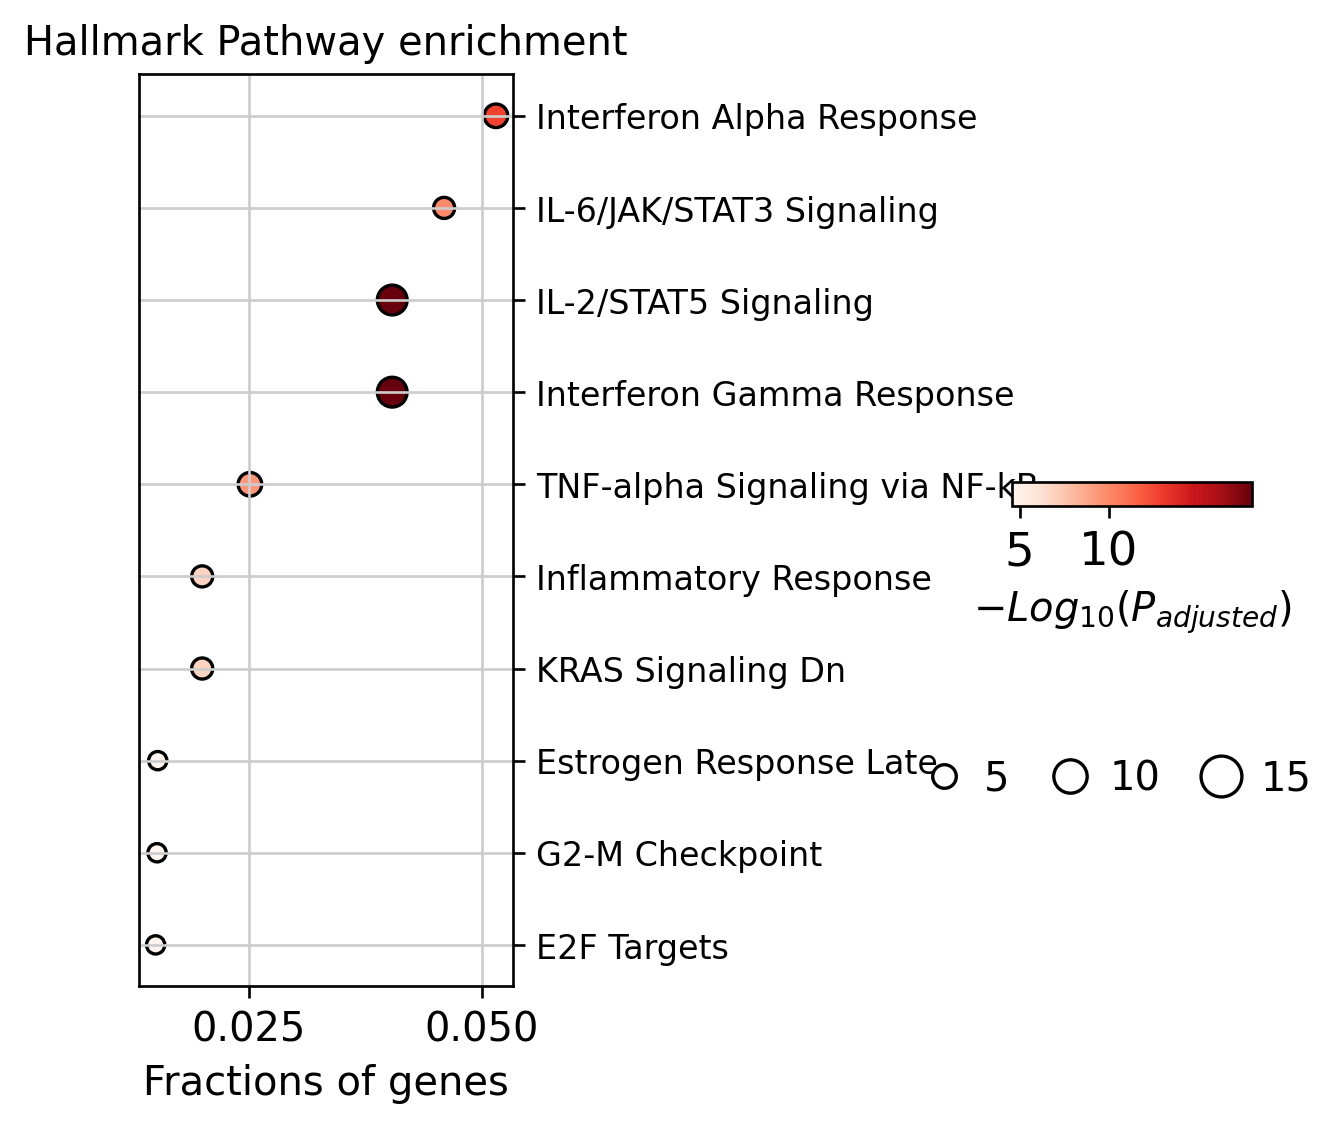

In [66]:
ov.bulk.geneset_plot(enr_down,figsize=(2,5),fig_title='Hallmark Pathway enrichment',
                        cmap='Reds')
#如果需要保存的话,使用`plt.savefig`来保存图像
plt.savefig("figures/T_after_pathway_down.svg",dpi=300,bbox_inches = 'tight')

#### 2T vs 其他

In [78]:
adata = sc.read_h5ad('/data/hanxue/hanxue_data/adata-xwt-annotated_T-0429.h5ad')

In [79]:
adata = adata[adata.obs['treat'].isin(['Before']), :]
adata = adata[adata.obs['batch'].isin(['2T', '9T']), :]

In [80]:
adata.obs['effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['9T']),'effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['2T']),'effect'] = 'worse'

In [81]:
# 选用高变基因
adata_highvar = adata[:, adata.var['highly_variable']].copy()

In [82]:
dds = ov.bulk.pyDEG(adata_highvar.to_df().T)
dds.drop_duplicates_index()

barcodes,AAACCCAAGTCTCTGA-1-2T,AAACCCACACGCAAAG-1-2T,AAACCCAGTAAGCTCT-1-2T,AAACCCAGTCTCGGAC-1-2T,AAACCCAGTTCCATTT-1-2T,AAACCCATCAGCTTCC-1-2T,AAACCCATCCGCATAA-1-2T,AAACCCATCTCAGTCC-1-2T,AAACGAAAGAAACACT-1-2T,AAACGAAAGGGAGTGG-1-2T,...,TTTGCGCTCATCGATG-1-9T,TTTGCGCTCTGTCTCG-1-9T,TTTGGTTAGAGCCTAG-1-9T,TTTGGTTAGCGTAATA-1-9T,TTTGGTTAGGATGTAT-1-9T,TTTGGTTCAGGCTGAA-1-9T,TTTGTCAAGTTGAGTA-1-9T,TTTGTCACACTAAGTC-1-9T,TTTGTCAGTGGTGTAG-1-9T,TTTGTCATCAAGGTAA-1-9T
name,,,,,,,,,,,,,,,,,,,,,
LTB,0.000000,0.000000,2.086199,0.000000,1.957171,1.767385,0.0,1.441383,2.859578,0.000000,...,2.317157,1.390067,0.000000,1.474361,1.480469,2.919789,2.749694,1.695476,2.805828,1.626230
JUN,2.089304,2.407371,1.510087,1.758024,0.000000,1.231907,0.0,1.441383,0.649258,0.000000,...,0.000000,1.101967,2.270718,1.474361,0.000000,2.820405,1.771435,0.442218,1.754711,1.112625
FOS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,3.719551,0.695664,0.000000,2.163190,1.182750,4.119102,3.804739,0.442218,2.100795,1.963891
TRAC,1.512849,1.673463,0.000000,2.361036,1.107381,1.767385,0.0,0.960602,1.869449,2.215358,...,1.538740,0.695664,0.000000,0.392837,0.000000,0.629605,0.000000,0.747782,0.786384,0.000000
MT2A,1.512849,1.913111,1.209383,0.000000,0.000000,0.000000,0.0,0.960602,0.000000,0.000000,...,2.118353,0.000000,0.000000,1.225506,2.307906,0.000000,1.771435,1.170815,0.786384,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000249955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CLDN24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000286055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
better_groups = adata_highvar.obs[adata_highvar.obs['effect']=='better'].index.tolist() # 实验组
worse_groups = adata_highvar.obs[adata_highvar.obs['effect']=='worse'].index.tolist() # 对照组
deg_result = dds.deg_analysis(better_groups, worse_groups, method='ttest')

In [84]:
# 将平均表达量低于1的基因全部过滤掉
print(deg_result.shape)
deg_result=deg_result.loc[deg_result['log2(BaseMean)']>0]
print(deg_result.shape)

(1507, 12)
(4, 12)


In [85]:
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 2.7241697311401367


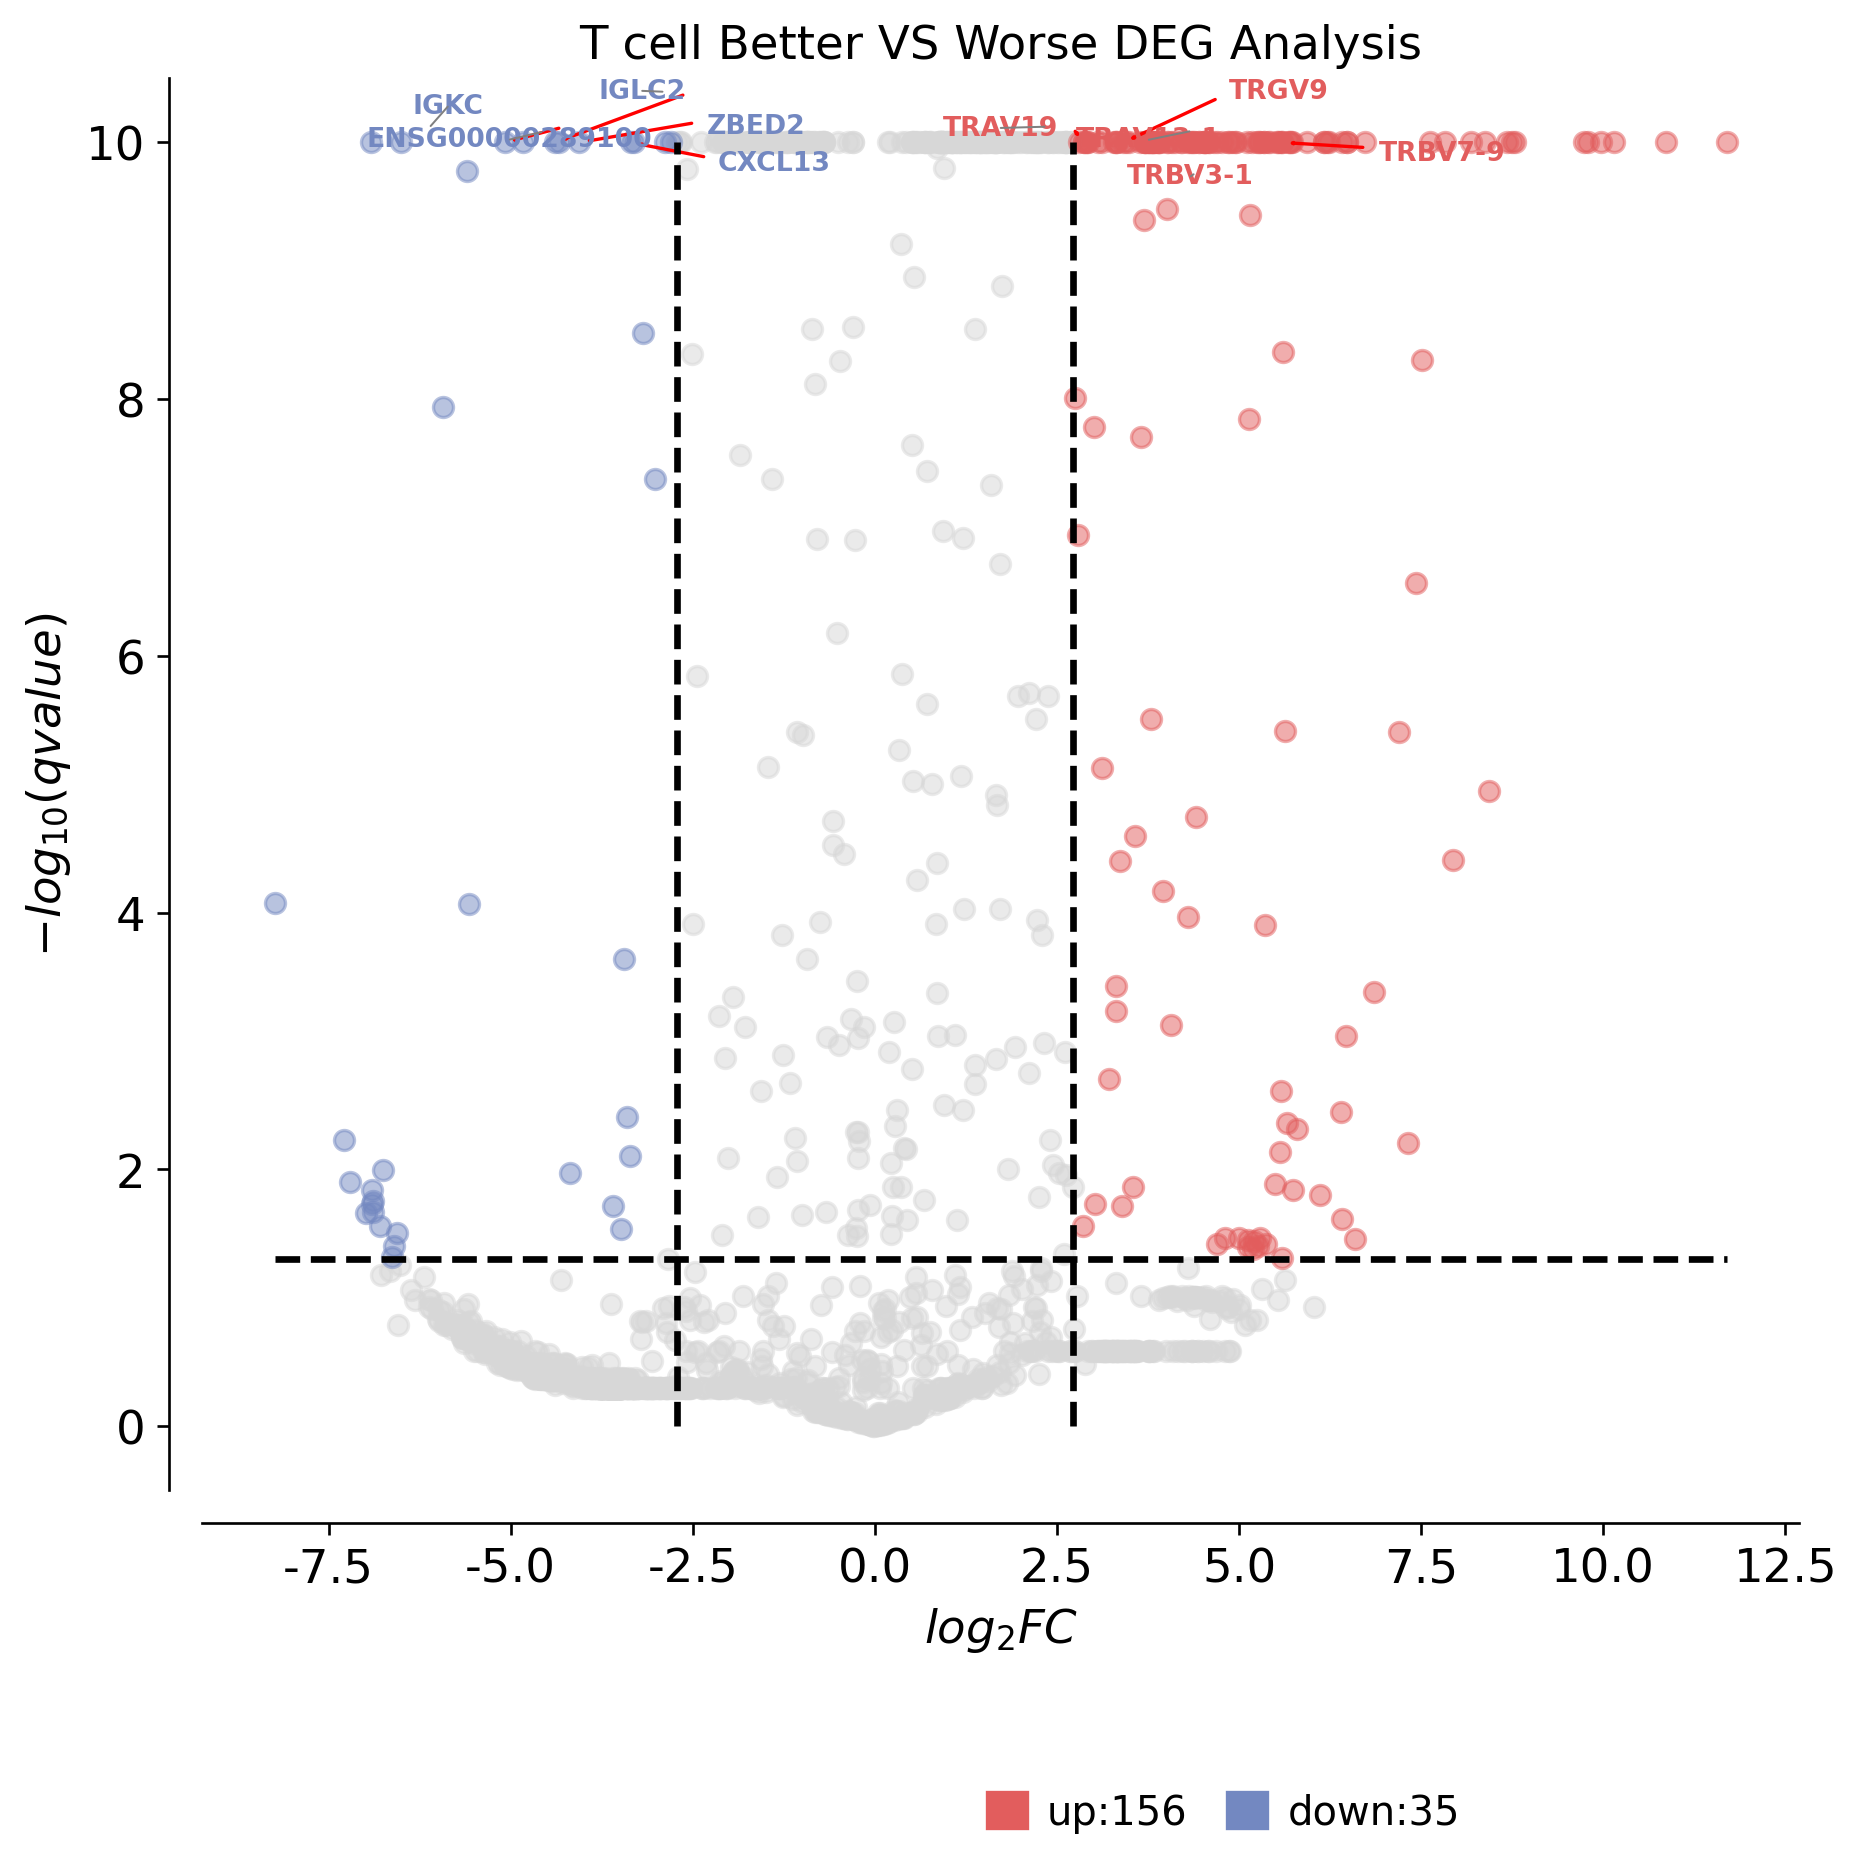

In [86]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 画火山图
dds.plot_volcano(
    title='T cell Better VS Worse DEG Analysis',
    figsize=(8, 8),
    plot_genes_num=10,
    plot_genes_fontsize=8,
)

# 获取当前图像和坐标轴
fig = plt.gcf()
ax = plt.gca()

# 获取所有文本对象（即基因名标签）
texts = [txt for txt in ax.texts]

# 调整文本位置，同时延长点和基因名之间的连线
adjust_text(
    texts,
    ax=ax,
    force_text=0.5,   # 增加文本之间的排斥力（默认是 0.1~0.5）
    force_points=1.5, # 增加点和文本之间的排斥力（数值越大，距离越远）
    expand_text=(1.1, 1.5),  # 扩展文本移动范围
    arrowprops=dict(
        arrowstyle='-', color='gray', lw=0.6,
        shrinkA=0, shrinkB=8  # 控制箭头起止点缩进距离，增大 shrinkB 可“拉长”箭头
    )
)

fig.tight_layout()
fig.savefig('figures/T-before-DEGs-Expression-Volcano.svg', format='svg')
